In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec
from sklearn.utils.class_weight import compute_class_weight


Now we need to make sure there are no invalid entries for our task, and delete them if they exist

In [35]:
reg_data = pd.read_csv("training_dataset.csv")

reg_data.head(20)

,Id,Title,Body,Score,ViewCount,Label,LabelNum,Title_Length,Body_Length,Title_Sentiment,Title_tokens,Body_tokens,Title_clean,Body_clean
0,197234,drop\stop mobile data connection (non-wifi) by...,<p>can i set android 4.4.2 to drop mobile data...,0,34,android,0,7,34,0.000000,"['drop', 'stop', 'mobile', 'data', 'connection...","['set', 'android', '4.4.2', 'drop', 'mobile', ...",drop stop mobile data connection non-wifi cond...,set android 4.4.2 drop mobile data connection ...
1,114800,how to automatically crop text messages when s...,<p>is there a way to prevent the messages app ...,0,836,android,0,12,49,0.000000,"['automatically', 'crop', 'text', 'messages', ...","['way', 'prevent', 'messages', 'app', 'sending...",automatically crop text messages sms character...,way prevent messages app sending long texts ge...
2,124532,can't find text message that was to a group,<p>when john doe texts to a group that include...,1,28,android,0,9,41,0.000000,"[""can't"", 'find', 'text', 'message', 'group']","['john', 'doe', 'texts', 'group', 'includes', ...",can't find text message group,john doe texts group includes appears notifica...
3,193875,can't store contacts on my android phone,<p>i was going through all of my installed app...,0,158,android,0,7,183,0.000000,"[""can't"", 'store', 'contacts', 'android', 'pho...","['going', 'installed', 'applications', 'phone'...",can't store contacts android phone,going installed applications phone ago clear j...
4,50332,dropbox on samsung galaxy - where is the setti...,"<p>on a sony xperia, the settings button in dr...",1,963,android,0,10,49,0.000000,"['dropbox', 'samsung', 'galaxy', 'settings', '...","['sony', 'xperia', 'settings', 'button', 'drop...",dropbox samsung galaxy settings button,sony xperia settings button dropbox top right....
5,41335,"rooted sgs3 and kies doesn't work with my rom,...",<p>recently rooted my sgs3 and installed a cus...,0,568,android,0,14,122,0.000000,"['rooted', 'sgs3', 'kies', 'work', 'rom', 'loo...","['recently', 'rooted', 'sgs3', 'installed', 'c...",rooted sgs3 kies work rom looking contact list...,recently rooted sgs3 installed custom rom impo...
6,218155,can i access play store via proxy?,<p>i have an issue with accessing play store w...,0,748,android,0,7,158,0.000000,"['access', 'play', 'store', 'via', 'proxy']","['issue', 'accessing', 'play', 'store', 'using...",access play store via proxy,issue accessing play store using fiddler inbet...
7,123843,iphone 5 ios7 no sound only vibrates when ring...,<p>here is what i tried...</p>\n\n<ol>\n<li><c...,5,220250,ios,1,9,109,-0.100000,"['iphone', '5', 'ios7', 'sound', 'vibrates', '...","['tried...', 'disturb', 'settings', 'sounds', ...",iphone 5 ios7 sound vibrates ringing,tried... disturb settings sounds vibrate ring ...
8,109824,how to stop creepypasta.wikia from suddenly re...,<p>for the past few days i've been reading the...,0,1308,android,0,12,94,0.000000,"['stop', 'creepypasta.wikia', 'suddenly', 'red...","['past', 'days', ""i've"", 'reading', 'creepypas...",stop creepypasta.wikia suddenly redirecting an...,past days i've reading creepypasta.wikia site ...
9,332070,is this an icloud sync/backup or do i have a d...,<p>what are these pictures showing my iphone's...,1,70,ios,1,12,224,0.000000,"['icloud', 'sync', 'backup', 'data', 'leak']","['pictures', 'showing', ""iphone's"", 'screen', ...",icloud sync backup data leak,pictures showing iphone's screen open video ap...


In [36]:
# Check for entries with viewCount = 0 and score > 0
invalid_entries = reg_data[(reg_data['ViewCount'] == 0) & (reg_data['Score'] > 0)]

invalid_entries

,Id,Title,Body,Score,ViewCount,Label,LabelNum,Title_Length,Body_Length,Title_Sentiment,Title_tokens,Body_tokens,Title_clean,Body_clean


No invalid entries

Score
 0    17279
 1    13483
 2     6974
 3     3847
 4     2215
 5     1468
-1     1130
-2      316
-3       83
Name: count, dtype: int64
Score Range: -3.0 - 5.0


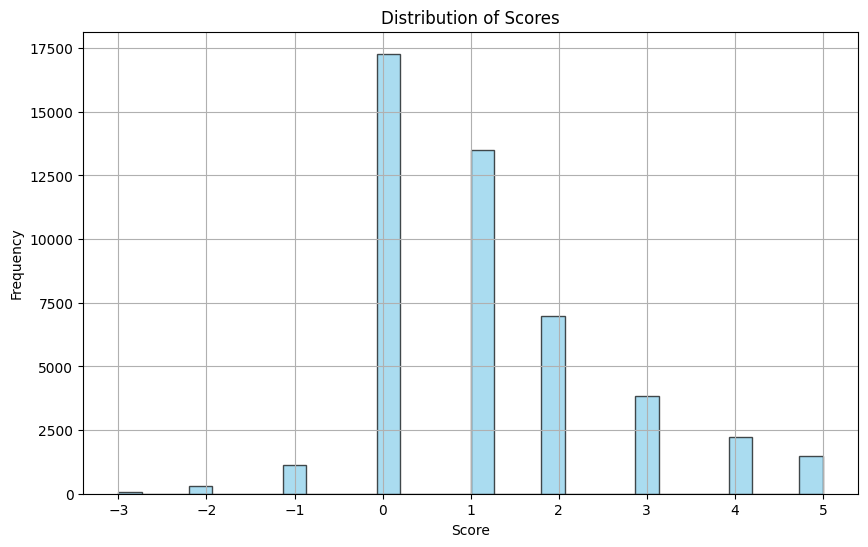

In [37]:
import matplotlib.pyplot as plt

score_distribution = reg_data['Score'].value_counts()
print(score_distribution)

score_range = reg_data['Score'].describe()
print("Score Range:", score_range['min'], "-", score_range['max'])


# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(reg_data['Score'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Building The Network

In [51]:
from sklearn.utils.class_weight import compute_class_weight

# Tokenize and pad sequences
X_title = reg_data['Title_tokens'].apply(lambda x: eval(x)).values
X_body = reg_data['Body_tokens'].apply(lambda x: eval(x)).values
X_combined = [title + body for title, body in zip(X_title, X_body)]

X_train, X_test, y_train, y_test = train_test_split(X_combined, reg_data['Score'].values, test_size=0.2, random_state=42)

reg_tokenizer = Tokenizer()
reg_tokenizer.fit_on_texts(X_combined)

X_train_seq = reg_tokenizer.texts_to_sequences(X_train)
X_test_seq = reg_tokenizer.texts_to_sequences(X_test)

maxlen = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')

# Word2Vec model for embeddings
embedding_dim = 100  # Dimensionality of Word2Vec embeddings
word2vec_model = Word2Vec(sentences=X_combined, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# Model architecture
reg_model = Sequential()

# Embedding layer
embedding_layer = Embedding(input_dim=len(reg_tokenizer.word_index) + 1, 
                             output_dim=embedding_dim, 
                             input_length=maxlen, trainable=False)

embedding_layer.build((None,))
embedding_layer.set_weights([np.vstack([np.zeros(embedding_dim), word2vec_model.wv.vectors])])

reg_model.add(embedding_layer)

# Dynamic sized bidirectional LSTM layers
num_lstm_layers = 0  # Number of LSTM layers
lstm_units = 64
for _ in range(num_lstm_layers):
    reg_model.add(Bidirectional(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))

# Final LSTM layer
reg_model.add(Bidirectional(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=False)))

# Dense layer for regression
reg_model.add(Dense(1))

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

reg_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
batch_size = 32
epochs = 10
reg_model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,class_weight=class_weights_dict)

# Evaluate the model
loss, mse = reg_model.evaluate(X_test_pad, y_test)
print("Mean Squared Error:", mse)

C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 35s 31ms/step - loss: 1.9818 - mean_squared_error: 1.9818 - val_loss: 1.7983 - val_mean_squared_error: 1.7983
Epoch 2/3
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 32s 31ms/step - loss: 1.8843 - mean_squared_error: 1.8843 - val_loss: 1.7827 - val_mean_squared_error: 1.7827
Epoch 3/3
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 32s 31ms/step - loss: 1.8032 - mean_squared_error: 1.8032 - val_loss: 1.7837 - val_mean_squared_error: 1.7837
293/293 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1.9143 - mean_squared_error: 1.9143
Mean Squared Error: 1.9077458381652832


In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

# Make predictions
y_pred = reg_model.predict(X_test_pad)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate Root Mean Squared Error (RMSE)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

# Calculate R-squared (R^2)
r_squared = r2_score(y_test, y_pred)
print("R-squared (R^2):", r_squared)

# Calculate Pearson correlation coefficient
correlation_coefficient = np.corrcoef(y_test, y_pred.squeeze())[0, 1]
print("Pearson Correlation Coefficient:", correlation_coefficient)

293/293 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
Mean Absolute Error: 1.0839211270658935
Root Mean Squared Error: 1.3812117203683794
R-squared (R^2): 0.04285148909237679
Pearson Correlation Coefficient: 0.21123497273298147


### Testing

In [53]:
user_input = input("Enter text: ")  # Input text

# Tokenize and pad the user input sequence
user_input_seq = reg_tokenizer.texts_to_sequences([user_input])
user_input_pad = pad_sequences(user_input_seq, maxlen=100, padding='post', truncating='post')

print("User input: ", user_input)

# Predict the score using the regression model
predicted_score = reg_model.predict(user_input_pad)

# Round the predicted score to the nearest integer
predicted_score_rounded = round(predicted_score[0][0])

print("Predicted Score: ", predicted_score_rounded)


User input:  reset ios without twrp?'
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Score:  1


The actual score for this question was 1. 
Note : many results will be 1 due to the imbalanced data since most questions had this score. However, we removed outliers and we mitigated overfitting by adding dropout layers to the model architecture. Dropout layers were added to the LSTM layers in the model architecture. For each LSTM layer, the dropout parameter was set to 0.2, meaning that during training, 20% of the input units to the LSTM layers were randomly set to zero.

In [22]:
from sklearn.utils.class_weight import compute_class_weight

# Tokenize and pad sequences
X_title = data_no_neg['Title_tokens'].apply(lambda x: eval(x)).values
X_body = data_no_neg['Body_tokens'].apply(lambda x: eval(x)).values
X_combined = [title + body for title, body in zip(X_title, X_body)]

X_train, X_test, y_train, y_test = train_test_split(X_combined, data_no_neg['Score'].values, test_size=0.2, random_state=42)

reg_tokenizer = Tokenizer()
reg_tokenizer.fit_on_texts(X_combined)

X_train_seq = reg_tokenizer.texts_to_sequences(X_train)
X_test_seq = reg_tokenizer.texts_to_sequences(X_test)

maxlen = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')

# Word2Vec model for embeddings
embedding_dim = 300  # Dimensionality of Word2Vec embeddings
word2vec_model = Word2Vec(sentences=X_combined, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# Model architecture
reg_model = Sequential()

# Embedding layer
embedding_layer = Embedding(input_dim=len(reg_tokenizer.word_index) + 1, 
                             output_dim=embedding_dim, 
                             input_length=maxlen, trainable=False)

embedding_layer.build((None,))
embedding_layer.set_weights([np.vstack([np.zeros(embedding_dim), word2vec_model.wv.vectors])])

reg_model.add(embedding_layer)

# Dynamic sized bidirectional LSTM layers
num_lstm_layers = 2  # Number of LSTM layers
lstm_units = 128
for _ in range(num_lstm_layers):
    reg_model.add(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))

# Final bidirectional LSTM layer
reg_model.add(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2))

# Dense layer for regression
reg_model.add(Dense(1))

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

reg_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
batch_size = 32
epochs = 10
reg_model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,class_weight=class_weights_dict)

# Evaluate the model
loss, mse = reg_model.evaluate(X_test_pad, y_test)
print("Mean Squared Error:", mse)

Epoch 1/10
1019/1019 [==============================] - 341s 327ms/step - loss: 1.8290 - mean_squared_error: 1.8290 - val_loss: 1.8136 - val_mean_squared_error: 1.8136
Epoch 2/10
1019/1019 [==============================] - 336s 330ms/step - loss: 1.8080 - mean_squared_error: 1.8080 - val_loss: 1.8069 - val_mean_squared_error: 1.8069
Epoch 3/10
1019/1019 [==============================] - 333s 326ms/step - loss: 1.8029 - mean_squared_error: 1.8029 - val_loss: 1.8075 - val_mean_squared_error: 1.8075
Epoch 4/10
1019/1019 [==============================] - 336s 330ms/step - loss: 1.7942 - mean_squared_error: 1.7942 - val_loss: 1.7898 - val_mean_squared_error: 1.7898
Epoch 5/10
1019/1019 [==============================] - 345s 339ms/step - loss: 1.7833 - mean_squared_error: 1.7833 - val_loss: 1.7704 - val_mean_squared_error: 1.7704
Epoch 6/10
1019/1019 [==============================] - 340s 334ms/step - loss: 1.7926 - mean_squared_error: 1.7926 - val_loss: 1.7850 - val_mean_squared_error:

In [39]:
user_input = input("Enter text: ")  # Input text

# Tokenize and pad the user input sequence
user_input_seq = reg_tokenizer.texts_to_sequences([user_input])
user_input_pad = pad_sequences(user_input_seq, maxlen=100, padding='post', truncating='post')

print("User input: ", user_input)

# Predict the score using the regression model
predicted_score = reg_model.predict(user_input_pad)

# Round the predicted score to the nearest integer
predicted_score_rounded = round(predicted_score[0][0])

print("Predicted Score: ", predicted_score)


User input:  i've looking root phone method require reboot, android twrp is so malicious
1/1 [==============================] - 0s 46ms/step
Predicted Score:  [[1.1238716]]


# Model 2 ( Using MAE )


The following model is just to be able to compare it against using a pretrained model that is made in milestone 3 both having a loss functions of Mean Absolute Error.

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec
from tensorflow.keras.initializers import Constant
import numpy as np
from sklearn.metrics import mean_absolute_error

# Hyperparameters
maxlen = 100  # Maximum sequence length
embedding_dim = 100  # Dimension of word embeddings
lstm_units = 128  # Number of LSTM units (increased for more complexity)
batch_size = 32  # Batch size for training
epochs = 5  # Number of training epochs

# Load the dataset
Reg_data = pd.read_csv("training_dataset.csv")

# Convert string representations of lists into actual lists
X_body = Reg_data['Body_tokens'].apply(lambda x: x.strip("[]").split(', ')).values
X_title = Reg_data['Title_tokens'].apply(lambda x: x.strip("[]").split(', ')).values

# Combine title and body
X_combined = [' '.join(title + body) for title, body in zip(X_title, X_body)]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, Reg_data['Score'].values, test_size=0.2, random_state=42)

# Initialize Tokenizer and fit on the combined text
Reg_tokenizer = Tokenizer()
Reg_tokenizer.fit_on_texts(X_combined)

# Convert tokens to sequences of integers
X_train_seq = Reg_tokenizer.texts_to_sequences(X_train)
X_test_seq = Reg_tokenizer.texts_to_sequences(X_test)

# Pad sequences to make them of equal length
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')

# Train the Word2Vec model
sentences = [sentence for sublist in X_body for sentence in sublist] + [sentence for sublist in X_title for sentence in sublist]
sentences = [sentence.split() for sentence in sentences]  # Tokenize sentences
word2vec_model = Word2Vec(sentences=sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((len(Reg_tokenizer.word_index) + 1, embedding_dim))

# Fill the embedding matrix with pretrained word vectors
for word, i in Reg_tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Define the LSTM model architecture with pretrained embeddings
Reg_model2 = Sequential()
Reg_model2.add(Embedding(input_dim=len(Reg_tokenizer.word_index) + 1, 
                         output_dim=embedding_dim, 
                         embeddings_initializer=Constant(embedding_matrix), 
                         input_length=maxlen, 
                         trainable=False))
Reg_model2.add(LSTM(units=lstm_units, dropout=0.05, recurrent_dropout=0.05))
Reg_model2.add(Dense(1, activation='linear'))  # Single output for regression

# Compile the model
Reg_model2.compile(
    optimizer='adam', 
    loss='mean_absolute_error', 
    metrics=['mean_absolute_error']
)

# Train the model
Reg_model2.fit(X_train_pad, y_train, batch_size=batch_size, epochs=3, validation_split=0.4)

# Evaluate the model
loss2, mae2 = Reg_model2.evaluate(X_test_pad, y_test)
print("Mean Absolute Error:", mae2)

# Make predictions and calculate MAE
y_pred = Reg_model2.predict(X_test_pad)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)


Epoch 1/3


C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


702/702 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - loss: 1.0621 - mean_absolute_error: 1.0621 - val_loss: 1.0375 - val_mean_absolute_error: 1.0375
Epoch 2/3
702/702 ━━━━━━━━━━━━━━━━━━━━ 25s 36ms/step - loss: 1.0228 - mean_absolute_error: 1.0228 - val_loss: 1.0377 - val_mean_absolute_error: 1.0377
Epoch 3/3
702/702 ━━━━━━━━━━━━━━━━━━━━ 26s 37ms/step - loss: 1.0246 - mean_absolute_error: 1.0246 - val_loss: 1.0332 - val_mean_absolute_error: 1.0332
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.0547 - mean_absolute_error: 1.0547
Mean Absolute Error: 1.0514600276947021
293/293 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Mean Absolute Error: 1.0514599633581148
